In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

C:\Users\deez\AppData\Local\Temp\ipykernel_9076\3460341112.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

def split(dataframe, border, col):
    return dataframe.loc[:border, col], dataframe.loc[border:, col]

In [3]:
tickers = ['COALINDIA.NS', 'IOC.NS', 'NMDC.NS', 'OIL.NS', 'ADANIPOWER.NS']
tickers = ['COALINDIA.NS']

In [4]:
df_new = {}

In [5]:
for ticker in tickers:
    df = yf.download(ticker, start='2011-01-01', progress=False)

    df_new[ticker] = {}
    df_new[ticker]["Train"], df_new[ticker]["Test"] = split(df, "2021", "Close")

In [6]:
print(list(df_new.keys()))

['COALINDIA.NS']


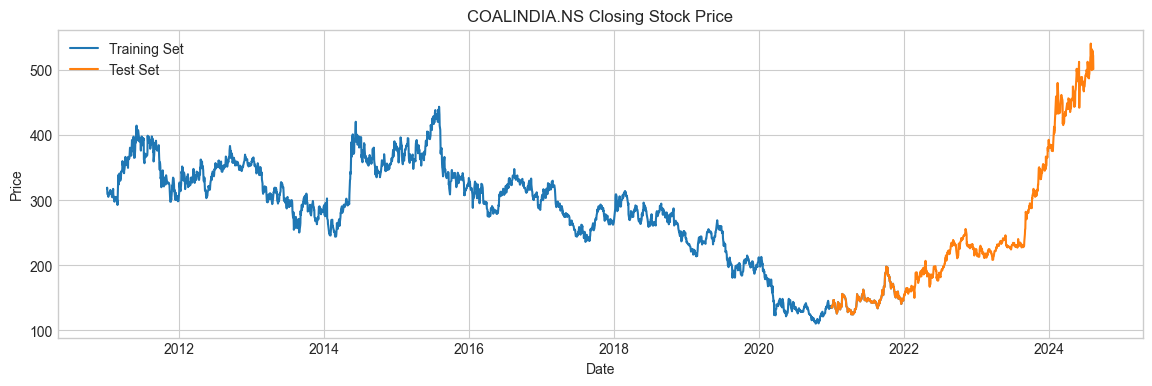

In [7]:
for i in tickers:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [8]:
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(tickers):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [9]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

COALINDIA.NS (2711, 1)


COALINDIA.NS (893, 1)


In [10]:
trainset = {}
testset = {}
for j in tickers:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2516):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 755):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [11]:
arr_buff = []
for i in tickers:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=tickers)

,X_train,y_train,X_test,y_test
COALINDIA.NS,"(2456, 60, 1)","(2456,)","(695, 60, 1)","(695,)"


In [12]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in tickers:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to COALINDIA.NS
Epoch 1/10
13/13 [==============================] - 94s 1s/step - loss: 0.0692
Epoch 2/10
13/13 [==============================] - 16s 1s/step - loss: 0.0242
Epoch 3/10
13/13 [==============================] - 16s 1s/step - loss: 0.0235
Epoch 4/10
13/13 [==============================] - 17s 1s/step - loss: 0.0230
Epoch 5/10
13/13 [==============================] - 16s 1s/step - loss: 0.0209
Epoch 6/10
13/13 [==============================] - 17s 1s/step - loss: 0.0186
Epoch 7/10
13/13 [==============================] - 17s 1s/step - loss: 0.0191
Epoch 8/10
13/13 [==============================] - 19s 1s/step - loss: 0.0197
Epoch 9/10
13/13 [==============================] - 17s 1s/step - loss: 0.0166
Epoch 10/10
13/13 [==============================] - 13s 991ms/step - loss: 0.0144
CPU times: total: 2min 15s
Wall time: 4min 44s


22/22 [==============================] - 16s 73ms/step


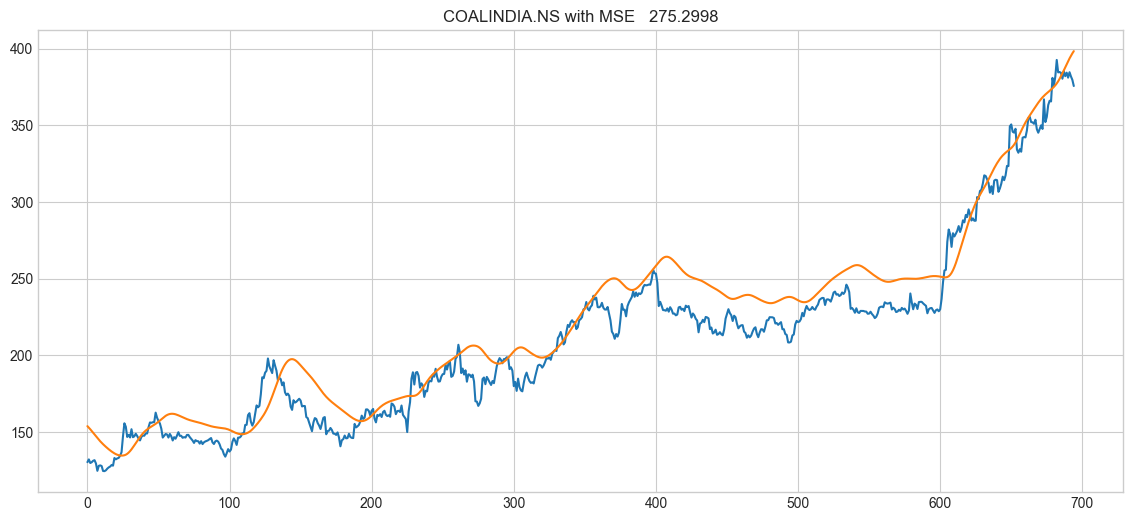

In [13]:
pred_result = {}
for i in tickers:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [14]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
for i in tickers:
    print("Fitting to", i)
    regressorGRU.fit(trainset[i]["X"], trainset[i]["y"],epochs=50,batch_size=150)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

In [ ]:
for i in tickers[3:]:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressorGRU.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)
    break